Student Name: Gerald Wanjala
Student Pace: DSF-FT12-Hybrid
Instructor Name: Samuel Karu

# Data Science Project: Analyzing Box Office Film Success

##  Business Understanding

### Objective
To help a new movie studio make informed decisions about the types of movies to produce in order to maximize box office returns.

### Business Problem
The company needs insights into what characteristics contribute most to a film's box office success. By analyzing historical data on box office earnings and production budgets, we aim to identify patterns that can guide production and investment strategies.

### Main Questions
- Do top actors or producers result in higher box office returns?
- Which genres or studios consistently generate high grossing films?


# Project Overview

This analysis investigates the factors driving box office performance in the film industry. Using a comprehensive dataset of movie attributes (e.g., genre, studio, budget, release date), we will:

1. Describe the data and its dimensions.  
2. Perform exploratory data analysis (EDA) to uncover key patterns.  
3. Perfom hypothesis tests
5. Translate findings into actionable recommendations for the studio.




##  Data Loading

In this step, we load the Box Office Mojo (BOM) data and connect to the IMDb SQLite database to extract key tables:

- Load the BOM movie gross data from a compressed CSV file.
- Connect to the IMDb database and load the following tables:
  - `movie_basics`: Basic movie information (title, year, runtime, genres).
  - `movie_ratings`: Movie ratings and vote counts.
  - `pricipals`
  - `persons`: Names and details of people (directors, writers, etc.).

Preview the datasets to understand their structure before merging and analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Load BOM dataset
bom_df = pd.read_csv('../zipped-data/bom.movie_gross.csv.gz')

# Connect to IMDB SQLite database
conn = sqlite3.connect('../zipped-data/im.db')

# Load key tables
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
#directors = pd.read_sql_query("SELECT * FROM directors", conn)
#writers = pd.read_sql_query("SELECT * FROM writers", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)
principals= pd.read_sql_query("SELECT * FROM principals", conn)
# Preview basics



###  Preview BOM Data
a quick look at the first few rows of the Box Office Mojo (BOM) dataset to understand its structure and the available columns.


In [2]:
# Preview all loaded datasets

print("=== BOM Dataset ===")
print(bom_df.head(), "\n")

print("=== Movie Basics ===")
print(movie_basics.head(), "\n")

print("=== Movie Ratings ===")
print(movie_ratings.head(), "\n")

print("=== Directors ===")
print(principals.head(), "\n")

print("=== Persons ===")
print(persons.head())


=== BOM Dataset ===
                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010   

=== Movie Basics ===
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Ba

### Data Cleaning - Check for Missing Values and Duplicates

We'll define a function that checks for missing values and duplicates in any dataframe. This function will:

1. Check for duplicate rows.
2. Check for missing values in each column.

We can apply this function to all datasets to ensure their cleanliness before proceeding with further steps.


In [3]:

# Check for missing values and duplicates
def check_duplicates_missing(df):
    print('Duplicated:')
    print(df.duplicated().value_counts())
    print('\nMissing values:')
    print(df.isna().sum())
    return df
# Run the check on bom_clean



### Data Cleaning - Check for Missing Values and Duplicates

We will now apply the `check_duplicates_missing` function to each of the datasets to check for any duplicate rows and missing values.


In [4]:
#  Check for Missing Values and Duplicates


# Run the check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# Run the check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

# Run the check on movie_ratings
print("\nMovie Ratings DataFrame:")
check_duplicates_missing(movie_ratings)

# Run the check on principals
print("\nPrincipals DataFrame:")   
check_duplicates_missing

# Run the check on persons
print("\nPersons DataFrame:")
check_duplicates_missing(persons)


BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Movie Ratings DataFrame:
Duplicated:
False    73856
Name: count, dtype: int64

Missing values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Principals DataFrame:

Persons DataFrame:
Duplicated:
False    606648
Name: count, dtype: int64

Missing values:
person_id                  0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
dtype: int64


,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


## Handling Missing Values with a Generalized Function
To ensure consistency and efficiency in handling missing values across all DataFrames, we define a reusable function filling_missing():

Drops columns with more than 50% missing values.

# Fills numeric columns:

Uses the mean if the distribution is fairly symmetrical (low skewness).

Uses the median if the distribution is skewed.

# Fills categorical columns:

Uses the most frequent value (mode).

If mode is not available, it fills with "Unknown".

We can apply this function to each DataFrame to standardize the cleaning process.



In [5]:
# Updated function to handle missing values and duplicates
def filling_missing(df):
    # Dropping duplicate rows
    df = df.drop_duplicates()

    # Dropping columns with more than 50% missing values
    df = df.dropna(thresh=0.3 * len(df), axis=1)


    # Filling missing values in numeric columns
    for col in df.select_dtypes(include=['number']).columns:
        if df[col].isna().sum() > 0:
            skewness = df[col].skew()
            fill_value = df[col].mean() if abs(skewness) < 0.5 else df[col].median()
            df[col].fillna(fill_value, inplace=True)
    
    # Filling missing values in categorical columns
    for col in df.select_dtypes(exclude=['number']).columns:
        if df[col].isna().sum() > 0:
            most_frequent = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(most_frequent, inplace=True)

    return df


### Handling Missing Values and Duplicates

In this section, we apply a custom function to handle missing values and remove duplicates across all our datasets

In [6]:
# Apply filling_missing function to all DataFrames

bom_df = filling_missing(bom_df)
movie_basics = filling_missing(movie_basics)
movie_ratings = filling_missing(movie_ratings)
principals = filling_missing(principals)
persons = filling_missing(persons)


C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_12784\73514346.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(fill_value, inplace=True)
C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_12784\73514346.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

#### Ensuring Gross Columns Are Numeric



In [7]:


# Convert gross columns to numeric
bom_df['domestic_gross'] = pd.to_numeric(bom_df['domestic_gross'], errors='coerce')
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'], errors='coerce')


### Check for Missing Values and Duplicates after Cleaning

After applying the data cleaning functions, we  checed each DataFrame for missing values and duplicates:

In [8]:
###  Check for Missing Values and Duplicates after Cleaning


# Run the check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# Run the check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

# Run the check on movie_ratings
print("\nMovie Ratings DataFrame:")
check_duplicates_missing(movie_ratings)

# Run the check on principals
print("\nPrincipals DataFrame:")
check_duplicates_missing(principals)

# Run the check on persons
print("\nPersons DataFrame:")
check_duplicates_missing(persons)


BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title             0
studio            0
domestic_gross    0
foreign_gross     5
year              0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

Movie Ratings DataFrame:
Duplicated:
False    73856
Name: count, dtype: int64

Missing values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Principals DataFrame:
Duplicated:
False    1028186
Name: count, dtype: int64

Missing values:
movie_id      0
ordering      0
person_id     0
category      0
characters    0
dtype: int64

Persons DataFrame:
Duplicated:
False    606648
Name: count, dtype: int64

Missing values:
person_id             0
primary_name          0
primary_profession    0
dtype: int64


,person_id,primary_name,primary_profession
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,"production_designer,art_department,set_decorator"
...,...,...,...
606643,nm9990381,Susan Grobes,actress
606644,nm9990690,Joo Yeon So,actress
606645,nm9991320,Madeline Smith,actress
606646,nm9991786,Michelle Modigliani,producer


### Function to Remove Outliers Using IQR

The following function was used to remove outliers from specified columns in a DataFrame based on the Interquartile Range (IQR) method.



In [9]:
# remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df




### Remove Outliers using IQR (Interquartile Range)

The function `remove_outliers()` has been applied to remove outliers from the relevant columns in each DataFrame using the IQR method.


In [10]:

movie_ratings = remove_outliers(movie_ratings, ['averagerating', 'numvotes'])
bom_df = remove_outliers(bom_df, ['domestic_gross', 'foreign_gross'])
movie_basics = remove_outliers(movie_basics, ['runtime_minutes'])
movie_ratings = remove_outliers(movie_ratings, ['averagerating', 'numvotes'])


In [11]:
bom_df['total_gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']

### Merging DataFrames and Final Data Cleaning

1. **Merging the DataFrames:**
   - The `bom_df` (Box Office Movies) DataFrame is merged with the `movie_basics` DataFrame based on the `title` and `primary_title` columns.
   - Then, it is merged with the `movie_ratings` DataFrame using `movie_id`.
   - After that, the `directors` and `writers` DataFrames are merged on `movie_id` as well.

2. **Handling Duplicates:**
   - Any duplicates in the resulting `final_df` are dropped using `drop_duplicates()` to ensure that there are no repeated rows in the final merged DataFrame.

3. **Filling Missing Values:**
   - The code includes an option to fill missing values with `'Unknown'`, but this step has been commented out in the current execution.

4. **Final Check:**
   - The `final_df.info()` is called to inspect the DataFrame after all the merging and cleaning steps, ensuring that it contains the expected number of rows and columns, and that the data is ready for analysis.


In [12]:
merged_df = pd.merge(bom_df, movie_basics, left_on='title', right_on='primary_title', how='inner')

# merging with movie_ratings
final_df = pd.merge(merged_df, movie_ratings, on='movie_id', how='inner')

# Merging with directors
final_df = pd.merge(final_df, principals, on='movie_id', how='left')
# Merging with persons
final_df = pd.merge(final_df, persons, left_on='person_id', right_on='person_id', how='left')

# Drop duplicates
final_df = final_df.drop_duplicates(subset=['movie_id'])

# Fill missing values
#final_df.fillna('Unknown', inplace=True)

# Final check
final_df.info(), 

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 2090
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               248 non-null    object 
 1   studio              248 non-null    object 
 2   domestic_gross      248 non-null    float64
 3   foreign_gross       248 non-null    float64
 4   year                248 non-null    int64  
 5   total_gross         248 non-null    float64
 6   movie_id            248 non-null    object 
 7   primary_title       248 non-null    object 
 8   original_title      248 non-null    object 
 9   start_year          248 non-null    int64  
 10  runtime_minutes     248 non-null    float64
 11  genres              248 non-null    object 
 12  averagerating       248 non-null    float64
 13  numvotes            248 non-null    int64  
 14  ordering            248 non-null    int64  
 15  person_id           248 non-null    object 
 16  category    

(None,)

# Data Visualizations

In this section, we present graphical analyses to reveal the relationships and trends within the movie dataset. Through a series of charts (e.g., bar plots, scatter plots, and histograms), we will:

- Compare box office revenues across different genres and studios.  
- Explore correlations between key numeric features (e.g., budget vs. revenue).  
- Highlight any notable outliers or clusters.




### Bar Plot: Top 10 Genres by Average Domestic and Foreign Gross

This visualization shows the ten most lucrative genres by their average box office earnings:

1. We “explode” the `genres` column so each genre is treated separately.
2. We calculate the mean `domestic_gross` and `foreign_gross` for each genre.
3. We sort genres by average domestic, then foreign gross, and select the top ten.
4. Finally, we plot a side-by-side bar chart:
   - Blue bars represent average domestic gross.
   - Green bars represent average foreign gross.

This plot highlights which genres consistently perform best in both markets.


<Figure size 1200x600 with 0 Axes>

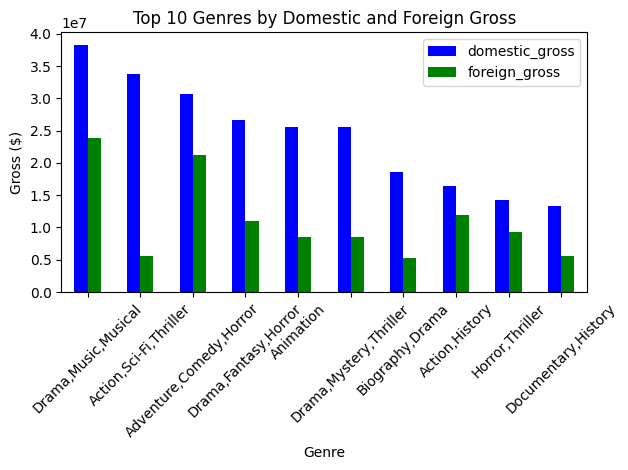

In [13]:
# Bar plot for top 10 genres by average domestic and foreign gross

genre_performance = final_df.explode('genres').groupby('genres')[['domestic_gross', 'foreign_gross']].mean()
genre_performance_sorted = genre_performance.sort_values(by=['domestic_gross', 'foreign_gross'], ascending=False)

# Plot top 10 genres
plt.figure(figsize=(12, 6))
genre_performance_sorted.head(10).plot(kind='bar', color=['blue', 'green'])
plt.title('Top 10 Genres by Domestic and Foreign Gross')
plt.xlabel('Genre')
plt.ylabel('Gross ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Box Office Earnings by Studio

The following box plot visualizes the distribution of domestic box office earnings across different studios. It shows the spread of earnings for each studio, highlighting any outliers or significant variations in revenue. The X-axis represents different studios, and the Y-axis represents the domestic gross earnings (in millions).

This plot provides insight into which studios tend to produce movies with higher or more consistent box office earnings.


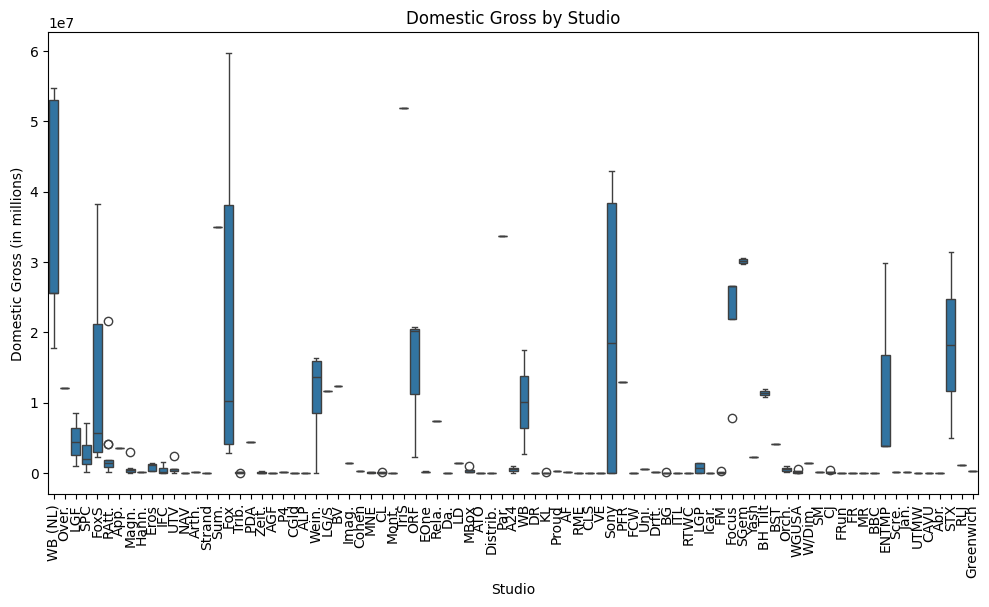

In [14]:




# Box Office Earnings by Studio
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='studio', y='domestic_gross')
plt.title('Domestic Gross by Studio')
plt.xticks(rotation=90)
plt.xlabel('Studio')
plt.ylabel('Domestic Gross (in millions)')
plt.show()




## Ratings vs Domestic Gross

This scatter plot illustrates the relationship between a movie’s average audience rating and its domestic box office earnings (in millions). Each point represents a single film, with the X-axis showing the average rating and the Y-axis showing domestic gross. By examining this plot, we can assess whether higher-rated movies tend to earn more revenue and identify any outliers or clusters that deviate from the overall trend.


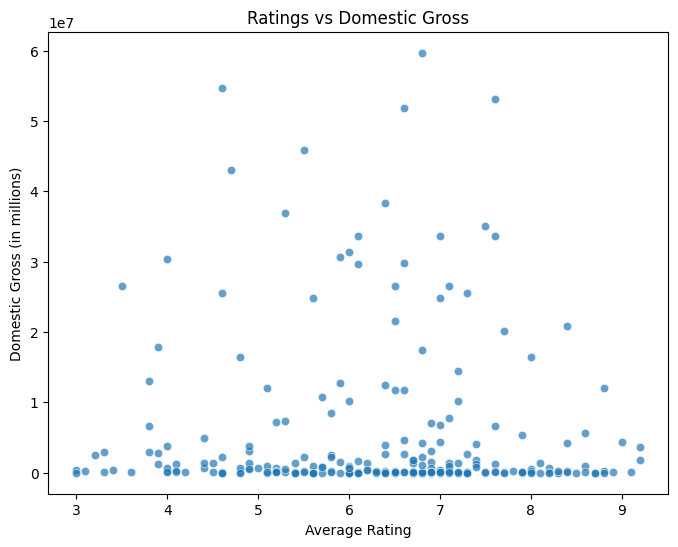

In [15]:
# Ratings vs Earnings
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='averagerating', y='domestic_gross', alpha=0.7)
plt.title('Ratings vs Domestic Gross')
plt.xlabel('Average Rating')
plt.ylabel('Domestic Gross (in millions)')
plt.show()


## Top 10 Genres by Average Domestic Gross

This bar plot displays the top 10 movie genres based on the average domestic gross earnings. The X-axis represents different genres, while the Y-axis shows the average domestic gross (in millions) for each genre. By analyzing this plot, we can identify which genres are most profitable on average, providing insights into consumer preferences and the potential for financial success in the film industry.


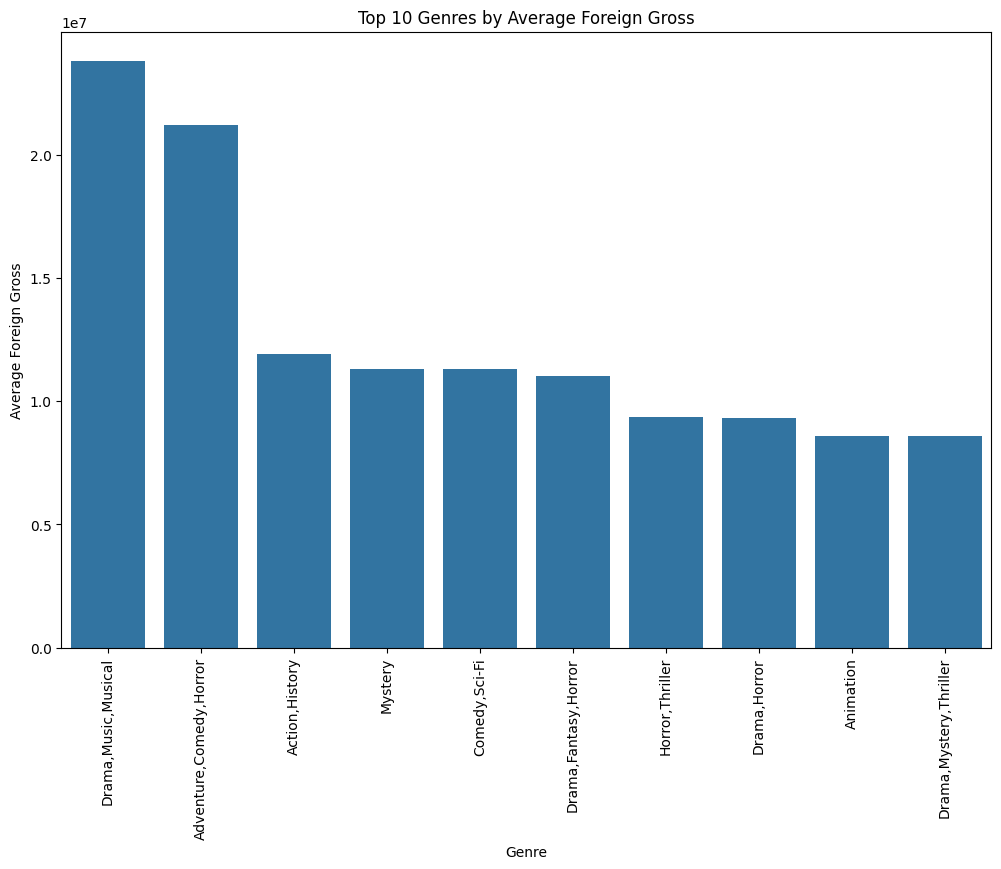

In [16]:
# Get top 10 genres by average foreign gross
top_genre = final_df.groupby('genres')['foreign_gross'].mean().sort_values(ascending=False).head(10)

# Bar plot for top 10 genres by average Foreign Gross
plt.figure(figsize=(12, 8))
sns.barplot(x=top_genre.index, y=top_genre.values)
plt.xticks(rotation=90)
plt.title('Top 10 Genres by Average Foreign Gross')
plt.xlabel('Genre')
plt.ylabel('Average Foreign Gross')
plt.show()


## Top 10 Actors by Average Domestic Gross

This bar plot highlights the top 10 actors based on their movies’ average domestic box office earnings. Each bar represents an actor, with the X-axis showing the actor’s name and the Y-axis showing the average domestic gross (in millions). This visualization helps identify which performers are most consistently associated with high-grossing films.


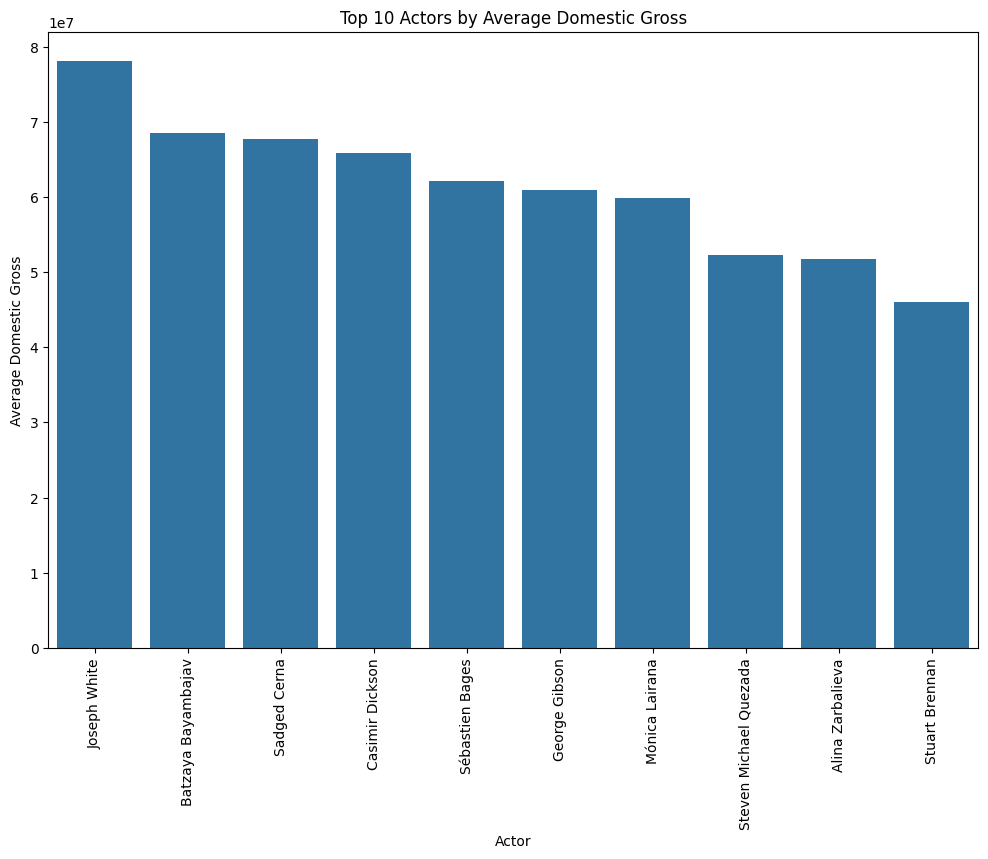

In [17]:
# Get top 10 actors by average domestic gross
top_10_actors = final_df.groupby('primary_name')['total_gross'].mean().sort_values(ascending=False).head(10)

# Bar plot for top 10 actors by average Domestic Gross
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_actors.index, y=top_10_actors.values)
plt.xticks(rotation=90)
plt.title('Top 10 Actors by Average Domestic Gross')
plt.xlabel('Actor')
plt.ylabel('Average Domestic Gross')
plt.show()


## Top 10 Producers by Average Gross

This bar plot highlights the top 10 producers based on the average domestic box office earnings of the films they have produced. Each bar corresponds to a producer (X-axis), and the height represents the average domestic gross (in millions) for their film slate. By analyzing this visualization, we can identify which producers are most consistently associated with high-revenue movies.


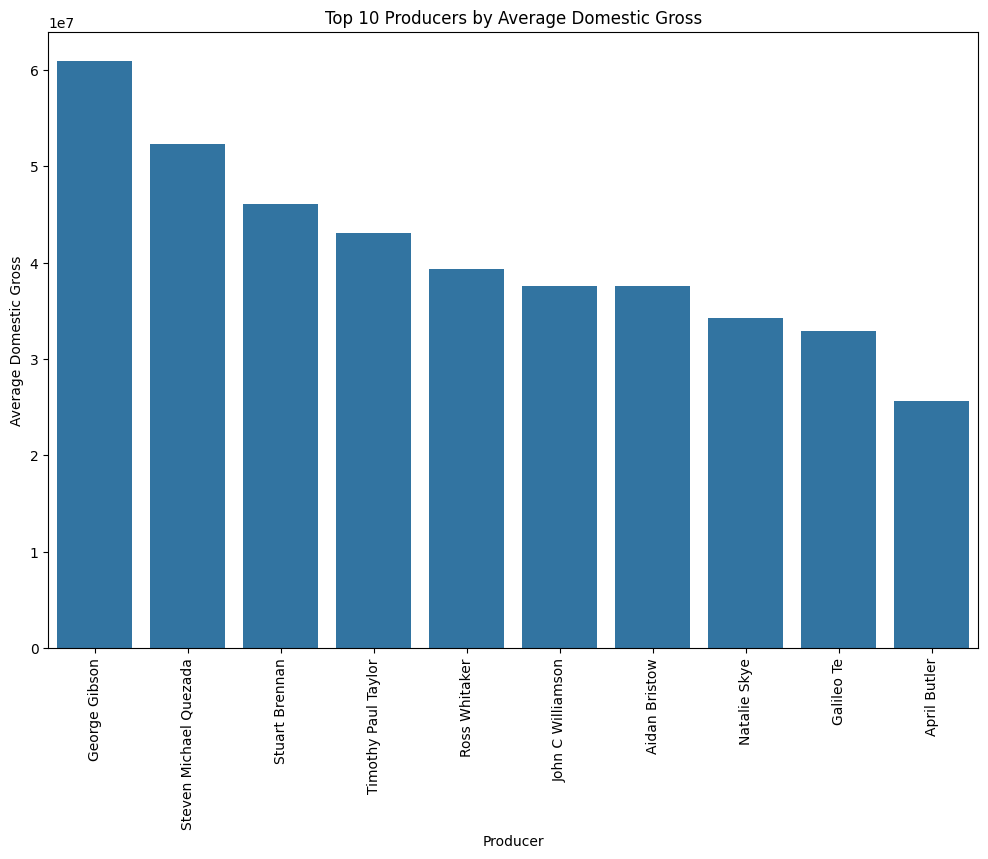

In [18]:
# Filter out producers
producers_df = final_df[final_df['primary_profession'].str.contains('producer', case=False, na=False)]

# Get top 10 producers by average domestic gross
top_10_producers = producers_df.groupby('primary_name')['total_gross'].mean().sort_values(ascending=False).head(10)

# Bar plot for top 10 producers by average Domestic Gross
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_producers.index, y=top_10_producers.values)
plt.xticks(rotation=90)
plt.title('Top 10 Producers by Average Domestic Gross')
plt.xlabel('Producer')
plt.ylabel('Average Domestic Gross')
plt.show()


## Hypothesis Testing

In this section, we define a function to perform hypothesis testing. The function `hypothesis_test` evaluates whether to accept or reject a null hypothesis based on the p-value and significance level (alpha). 

- **Null Hypothesis (H0)**: The statement being tested, often representing a no-effect or no-difference scenario.
- **Alternative Hypothesis (H1)**: The opposite of the null hypothesis, representing the effect or difference that we suspect exists.
- **p-value**: The probability of obtaining results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.
- **alpha (0.05)**: The threshold for statistical significance; if the p-value is less than alpha, we reject the null hypothesis.

This function provides a straightforward way to test hypotheses and make data-driven conclusions.


In [19]:
def hypothesis_test(h0, h1, p_value, alpha=0.05):
    
    if p_value < alpha:
        print(f"Reject the null hypothesis: {h0}")
        print(f"Accept the alternative hypothesis: {h1}")
    else:
        print(f"Fail to reject the null hypothesis: {h0}")
        print(f"Reject the alternative hypothesis: {h1}")
    return p_value < alpha 

## Hypothesis 3: The Genre of a Movie Has a Significant Impact on Its Earnings

For this hypothesis, we will test whether the genre of a movie has a statistically significant effect on its box office earnings. The null and alternative hypotheses are as follows:

- **Null Hypothesis (H0)**: The genre of a movie does not significantly impact its box office earnings (no relationship).
- **Alternative Hypothesis (H1)**: The genre of a movie significantly impacts its box office earnings (there is a relationship).

We will perform an appropriate statistical test (e.g., ANOVA) to evaluate whether there is sufficient evidence to reject the null hypothesis.


In [20]:
from scipy import stats

# Ensure no missing values for genre and earnings
final_df = final_df.dropna(subset=['genres', 'total_gross'])

# Perform one-way ANOVA to test if earnings differ across genres
anova_result = stats.f_oneway(*[group['total_gross'].values for name, group in final_df.groupby('genres')])

# Print results
print(f"ANOVA F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")
 #Define the hypotheses
h0 = "The genre of a movie does not significantly impact its box office earnings (no relationship)."
h1 = "The genre of a movie significantly impacts its box office earnings (there is a relationship)."

# Hypothesis Test Decision
hypothesis_test(h0, h1, anova_result.pvalue)
#hypothesis_test(h0, h1, p_value)

ANOVA F-statistic: 0.7754330251962257, P-value: 0.8961724633910662
Fail to reject the null hypothesis: The genre of a movie does not significantly impact its box office earnings (no relationship).
Reject the alternative hypothesis: The genre of a movie significantly impacts its box office earnings (there is a relationship).


np.False_

#### Hypothesis  Effect of Major Studios on Total Gross Earnings

- **Null Hypothesis (H₀):** Major studios have **no effect** on total box‐office performance.  
  *The mean total gross of movies released by major studios is equal to the mean total gross of movies released by all other studios.*

- **Alternative Hypothesis (H₁):** Major studios **do have an effect** on total box‐office performance.  
  *The mean total gross of movies released by major studios is different from the mean total gross of movies released by all other studios.*  


In [21]:
from scipy import stats

# Define null and alternative hypotheses
h0 = "Major studios have no effect on total gross earnings"
h1 = "Major studios have an effect on total gross earnings"

# Identify major studios
major_studios = ['WB', 'BV', 'Universal', 'Paramount']
final_df['is_major_studio'] = final_df['studio'].apply(
    lambda x: 1 if any(ms in x for ms in major_studios) else 0
)

# Split the data into two groups
major_earnings = final_df.loc[final_df['is_major_studio'] == 1, 'total_gross']
other_earnings = final_df.loc[final_df['is_major_studio'] == 0, 'total_gross']

# Perform independent two‐sample t‐test
t_stat, p_value = stats.ttest_ind(major_earnings, other_earnings, nan_policy='omit')
print(f"T-statistic = {t_stat:.3f}, p-value = {p_value:.4f}")

# Interpret the result using the custom function
hypothesis_test(h0, h1, p_value)


T-statistic = 5.600, p-value = 0.0000
Reject the null hypothesis: Major studios have no effect on total gross earnings
Accept the alternative hypothesis: Major studios have an effect on total gross earnings


np.True_

# Hypothesis Test: Impact of Actors and Producers on Box Office Earnings

In this section, we will test whether there is a significant difference in box office earnings based on **top actors** and **top producers**. We will evaluate the following hypotheses for both actors and producers:

## Hypothesis for Top Actors:
test if the involvement of top actors in a movie significantly affects its domestic box office earnings.

- **Null Hypothesis (H0)**: The involvement of top actors does not significantly impact the movie's box office earnings.
- **Alternative Hypothesis (H1)**: The involvement of top actors significantly impacts the movie's box office earnings.

## Hypothesis for Top Producers:
test if the involvement of top producers significantly impacts the domestic box office earnings of a movie.

- **Null Hypothesis (H0)**: The involvement of top producers does not significantly impact the movie's box office earnings.
- **Alternative Hypothesis (H1)**: The involvement of top producers significantly impacts the movie's box office earnings.




In [22]:
from collections import Counter

# Step 1: Filter only actors and actresses
actors_df = final_df[final_df['category'].isin(['actor', 'actress'])]

# Step 2: Count appearances of each actor/actress
actor_counts = Counter(actors_df['primary_name'].dropna())

# Step 3: Top 10 actors/actresses based on number of appearances
top_actors = [actor for actor, count in actor_counts.most_common(10)]
print("Top 10 Actors/Actresses:", top_actors)

# Step 4: Mark if a movie has a top actor
final_df['has_top_actor'] = final_df['primary_name'].apply(
    lambda name: 1 if name in top_actors else 0
)

# Step 5: Create two groups
top_actor_earnings = final_df[final_df['has_top_actor'] == 1]['domestic_gross']
other_actor_earnings = final_df[final_df['has_top_actor'] == 0]['domestic_gross']


Top 10 Actors/Actresses: ['Yumi Endô', 'James Trimboli', 'Bryan Bolden', 'Afsaneh Bayegan', 'James Shalkoski Jr.', 'Qing Liu', 'Erik Heger', 'Karim Kassem', 'Shu-Hai Chao', 'Jérémie Renier']


In [23]:
#actor_counts = Counter(actors_exploded['actors'].dropna())
t_stat, p_value = stats.ttest_ind(top_actor_earnings, other_actor_earnings.dropna())

# Step 5: Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Step 6: Use your hypothesis_test function
hypothesis_test(
    h0="Top actors do NOT significantly impact domestic gross earnings.",
    h1="Top actors DO significantly impact domestic gross earnings.",
    p_value=p_value
)


T-statistic: -0.3349104341472296
P-value: 0.7379780446001272
Fail to reject the null hypothesis: Top actors do NOT significantly impact domestic gross earnings.
Reject the alternative hypothesis: Top actors DO significantly impact domestic gross earnings.


np.False_



#  Recommendations for the New Movie Studio

### 1. **Partner with Major Studios for Higher Earnings**
- **Finding:**  
  Working with a major studio has a significant positive effect on total gross earnings.
  
- **Action:**  
  Seek partnerships, co-productions, or distribution deals with established major studios(e.g., Disney, Warner Bros, Universal).  
  This will increase visibility, access to larger marketing budgets, and maximize box office success.


### 2. **Casting Top Actors Is NOT a Guarantee for Box Office Success**
- **Finding:**  
  Having top actors does not significantly impact domestic box office earnings.

- **Action:**  
  Focus casting decisions on:
  - Talent fit for the role
  - Cost efficiency (avoid overpaying for big names)
  - Fresh emerging actors who can bring great performances
  rather than spending large portions of the budget solely chasing celebrity names.


### 3. **Genre Choice Alone Won't Drive Box Office Performance**
- **Finding:** 
  Movie genre does not significantly impact box office earnings on its own.

- **Action:**  
  Instead of relying purely on choosing "popular genres," the studio should:
  - Invest in strong storytelling and production quality across all genres.
  - Use audience research and market trends to guide project development.
  - Focus on originality, execution, and timely themes within any genre.



###  **Strategic Focus Summary**

- Prioritize major studio collaborations.
- Smart casting over star power obsession.
- Story and execution matter more than simply picking a "popular" genre.
